# Imports

In [1]:
from pathlib import Path
import os
import pandas as pd
import torch as tc
import torchvision as tv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary as ts
import numpy as np
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.metrics import classification_report

# Dataset and Dataloader

In [2]:
output_folder = Path(r"C:/Users/Michał/Documents/ISWD/workdir_doubled/beer_labels")

os.chdir(output_folder)

dirs = [d for d in os.listdir() if os.path.isdir(d)]

print(f"Output folder path: {output_folder}")

dataset_path = Path("C:/Users/Michał/Documents/ISWD/workdir_doubled/")
training_csv_path = os.path.join(dataset_path, "training.csv")
validation_csv_path = os.path.join(dataset_path, "validation.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

classes = []
for name in os.listdir(output_folder):
    dir_path = os.path.join(output_folder, name)
    if os.path.isdir(dir_path) and any(os.scandir(dir_path)):
        classes.append(name)

print("Liczba klas: " + str(len(classes)))
num_classes = len(classes)

Output folder path: C:\Users\Michał\Documents\ISWD\workdir_doubled\beer_labels
Liczba klas: 95


In [3]:
all_cases = []

for current_class in classes:
    class_path = os.path.join(output_folder, current_class)
    image_files = os.listdir(class_path)

    for i in range(len(image_files)):
        image_path = os.path.join(class_path, image_files[i])
        all_cases.append((image_path,  current_class))
      
train_cases, test_cases = train_test_split(all_cases, test_size=0.2, random_state=42)
train_cases, val_cases = train_test_split(train_cases, test_size=0.125, random_state=42)

train_df = pd.DataFrame(train_cases, columns=["image_path", "image_class_name"])
train_df.to_csv(training_csv_path)

val_df = pd.DataFrame(val_cases, columns=["image_path", "image_class_name"])
val_df.to_csv(validation_csv_path)

test_df = pd.DataFrame(test_cases, columns=["image_path", "image_class_name"])
test_df.to_csv(testing_csv_path)


In [4]:
class BeerDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(csv_path)
        self.transforms = transforms
        self.z_norm = z_norm

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.at[idx, 'image_path']
        current_class = self.dataframe.at[idx, 'image_class_name']

        current_image = tv.io.read_image(image_path)
        current_image = current_image.numpy()
        current_image = tc.from_numpy(current_image)
      

        if (len(current_image.shape) == 2):
          current_image = current_image.unsqueeze(2)
        #print(current_image.shape)
      
        if current_image.shape[2] == 1:
            current_image = current_image.repeat(1, 1, 3)
        if current_image.shape[2] == 4:
            current_image = current_image[:, :, :3]

        #current_image = current_image.permute(2, 0, 1)
        current_image = tv.transforms.functional.resize(current_image, (224,224), antialias=True)
        
        #print(current_image.shape)

        if self.transforms is not None:
          current_image = self.transforms(current_image)

        if self.z_norm:
          current_image = current_image.numpy()
          current_image = current_image.astype(np.float32)
          current_image = tc.from_numpy(current_image)
          current_image = tv.transforms.functional.normalize(current_image, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        else:
            current_image = current_image / 255.0
            current_image = (current_image - 0.5) / 0.5

        return current_image, current_class


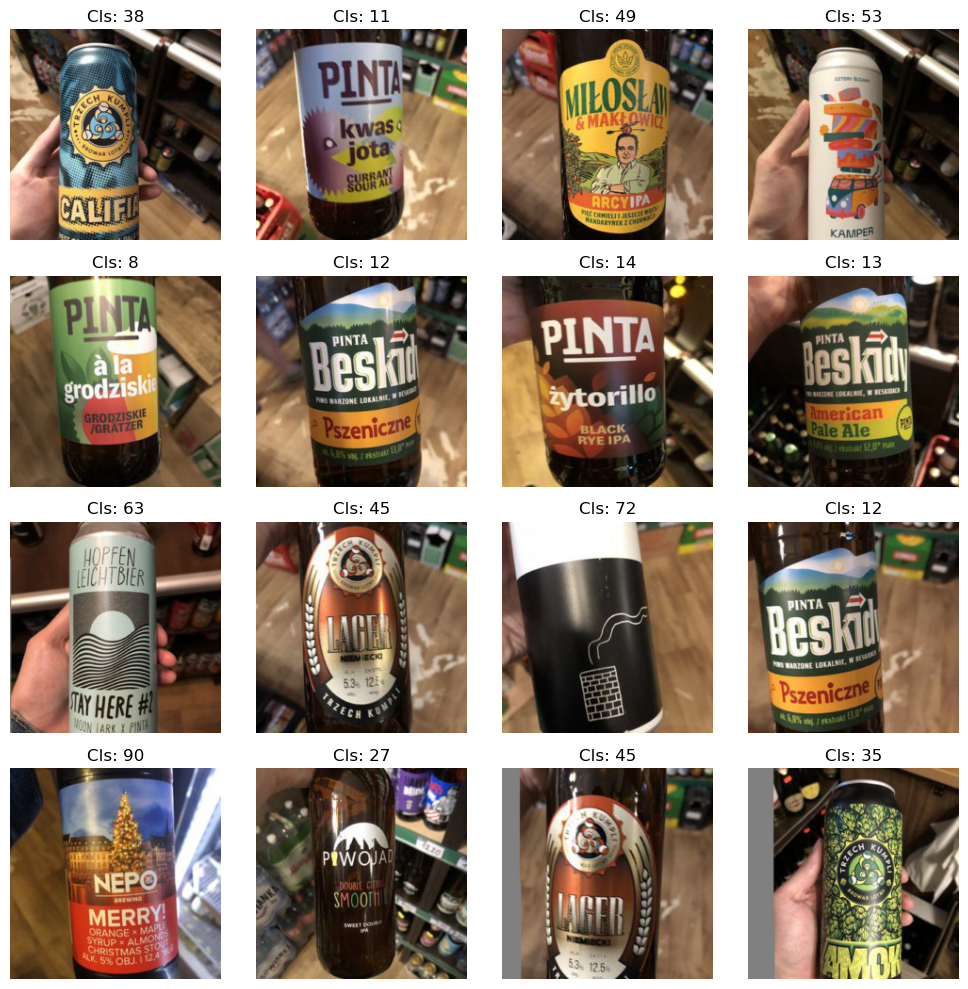

In [6]:
batch_size = 16
shuffle = True
# transforms = tc.nn.Sequential(
#   tv.transforms.AutoAugment(policy=tv.transforms.AutoAugmentPolicy.IMAGENET),
# )
dataset = BeerDataset(os.path.join(dataset_path, "tmp"), training_csv_path, z_norm=False)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

for images, classes in dataloader:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        image = (image + 1) / 2
        ax.set_title("Cls: " + str(classes[i].item()))
        ax.imshow(image)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    break

# Neural Networks Architectures

In [7]:
class ClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, 1, 1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU(),
            tc.nn.Conv2d(32, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [8]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"

classification_network = ClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(classification_network.to(device), (3, 224, 224))

Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 95])
Random output: 
tensor([[-2.9041e-02,  7.9018e-02, -7.0599e-02,  5.1410e-03,  5.4186e-02,
          6.5075e-02, -7.4531e-02, -9.6893e-02, -1.0594e-01, -9.4964e-02,
         -1.0166e-01,  1.3387e-01,  7.5800e-02,  2.0535e-02, -1.2437e-01,
          5.0053e-02, -1.1368e-01, -6.0899e-02,  4.7354e-02,  6.0754e-02,
         -3.0518e-02,  6.2613e-02,  6.1875e-03,  9.4422e-02, -8.3782e-02,
         -5.7901e-02, -3.3778e-02, -6.5062e-02, -1.2044e-01,  1.5518e-01,
         -6.9247e-02,  1.6216e-01,  2.5961e-02,  8.5089e-02, -2.4898e-02,
         -5.2297e-02,  1.7142e-01,  2.4310e-02, -7.6128e-02,  7.5122e-02,
         -4.5846e-02,  1.4590e-02,  4.4247e-02, -1.2231e-01, -1.7596e-01,
         -1.3172e-01, -8.0590e-02, -7.9203e-02, -6.8623e-02,  1.2791e-03,
         -4.7692e-02,  7.6780e-02, -1.1060e-01, -6.6790e-03,  6.4352e-03,
          9.3599e-03,  3.7114e-02,  5.9405e-02, -6.4224e-02, -8.8609

In [ ]:
class ImprovedClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ImprovedClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 128, 3, 2, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 128, 3, 1, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 256, 3, 2, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 256, 3, 1, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 512, 3, 2, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.Conv2d(512, 512, 3, 1, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [ ]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
print("Device: " + device)

improved_classification_network = ImprovedClassificationNetwork()
batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = improved_classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(improved_classification_network.to(device), (3, 224, 224))

# Training

In [9]:
def training(model, training_dataloader, validation_dataloader, num_epochs, learning_rate):
  
  objective_function = tc.nn.CrossEntropyLoss() 
  parameters = model.parameters() 
  optimizer = tc.optim.Adam(parameters, learning_rate) 
  device = "cuda:0" if tc.cuda.is_available() else "cpu" 
  training_losses = []
  testing_losses = [] 
  model = model.to(device)
  
  print(f"Training dataset size: {len(training_dataloader.dataset)}")
  print(f"Testing dataset size: {len(validation_dataloader.dataset)}")
  for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")

    training_epoch_loss = 0.0
    model.train()
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_epoch_loss += loss.item() * images.size(0)

    training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
    training_losses.append(training_epoch_loss)
    print(f"Current epoch training loss: {training_epoch_loss}")

    testing_epoch_loss = 0.0
    model.eval()
    for images, classes in validation_dataloader:
      with tc.set_grad_enabled(False):
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        testing_epoch_loss += loss.item() * images.size(0)

    testing_epoch_loss = testing_epoch_loss / len(validation_dataloader.dataset)
    testing_losses.append(testing_epoch_loss)
    print(f"Current epoch validation loss: {testing_epoch_loss}")

  # Return the trained model and the history of training and testing losses
  return model, training_losses, testing_losses

In [10]:
learning_rate = 0.002
batch_size = 32
num_epochs = 25 
shuffle = True
# transforms = tc.nn.Sequential(
#   tv.transforms.AutoAugment(policy=tv.transforms.AutoAugmentPolicy.IMAGENET),
# )

#Trainig dataset/dataloader
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path, z_norm=True)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
# Validation dataset/dataloader
validation_dataset = BeerDataset(os.path.join(dataset_path, "Validation"), validation_csv_path, z_norm=True)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# Testing dataset/dataloader
testing_dataset = BeerDataset(os.path.join(dataset_path, "Testing"), testing_csv_path, z_norm=True)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [11]:
classification_model, training_losses, testing_losses = training(classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 6862
Testing dataset size: 981
Current epoch: 0
Current epoch training loss: 3.296492925297585
Current epoch validation loss: 2.3514149490360334
Current epoch: 1
Current epoch training loss: 1.943981824064352
Current epoch validation loss: 1.9071452104838738
Current epoch: 2
Current epoch training loss: 1.5241185436093123
Current epoch validation loss: 21.802353253301373
Current epoch: 3
Current epoch training loss: 1.1250630998639246
Current epoch validation loss: 1.4189000762809185
Current epoch: 4
Current epoch training loss: 0.8238558875545056
Current epoch validation loss: 0.8078289669345036
Current epoch: 5
Current epoch training loss: 0.6953070451413463
Current epoch validation loss: 0.7356346514489915
Current epoch: 6
Current epoch training loss: 0.5179827987226999
Current epoch validation loss: 0.5819972662386179
Current epoch: 7
Current epoch training loss: 0.44886444205012693
Current epoch validation loss: 0.2956028694285044
Current epoch: 8
Current ep

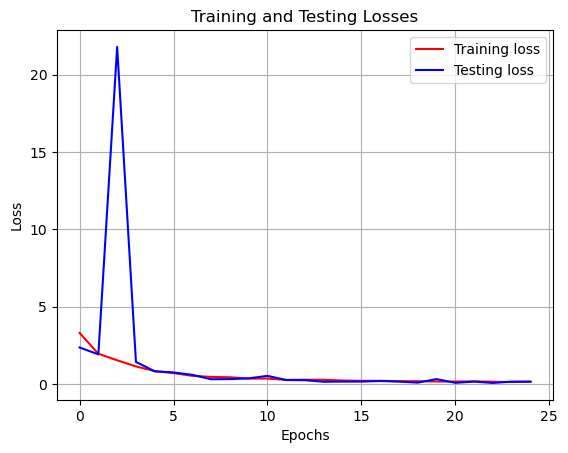

In [12]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [13]:
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models doubled")
os.chdir(new_dir)
tc.save(classification_model.state_dict(), "classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

Saved model file classification_model.pt found in C:\Users\Michał\Documents\ISWD\saved models doubled.


In [ ]:
improved_classification_model, training_losses, testing_losses = training(improved_classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

In [ ]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [ ]:
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models doubled")
os.chdir(new_dir)
tc.save(improved_classification_model.state_dict(), "improved_classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'improved_classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

# Evaluation

In [15]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models doubled")
os.chdir(new_dir)

classification_model = ClassificationNetwork().to(device)
classification_model.load_state_dict(tc.load('classification_model.pt'))

# improved_classification_model = ImprovedClassificationNetwork().to(device)
# improved_classification_model.load_state_dict(tc.load('improved_classification_model.pt'))

<All keys matched successfully>

In [16]:
def accumulate_predictions(model, dataloader):
  predictions = []
  targets = []
  
  model.eval()
  with tc.set_grad_enabled(False):
      print(f"Dataset size: {len(dataloader.dataset)}")
      for images, classes in dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        pred = output.argmax(dim=1)

        predictions.append(pred.cpu())
        targets.append(classes.cpu())
  predictions = tc.cat(predictions)
  targets = tc.cat(targets)
  return predictions, targets

Dataset size: 6862
Dataset size: 1961
Training Accuracy: 0.9621101719615273
Testing Accuracy: 0.9535951045385007
Training Report:
Testing Report:


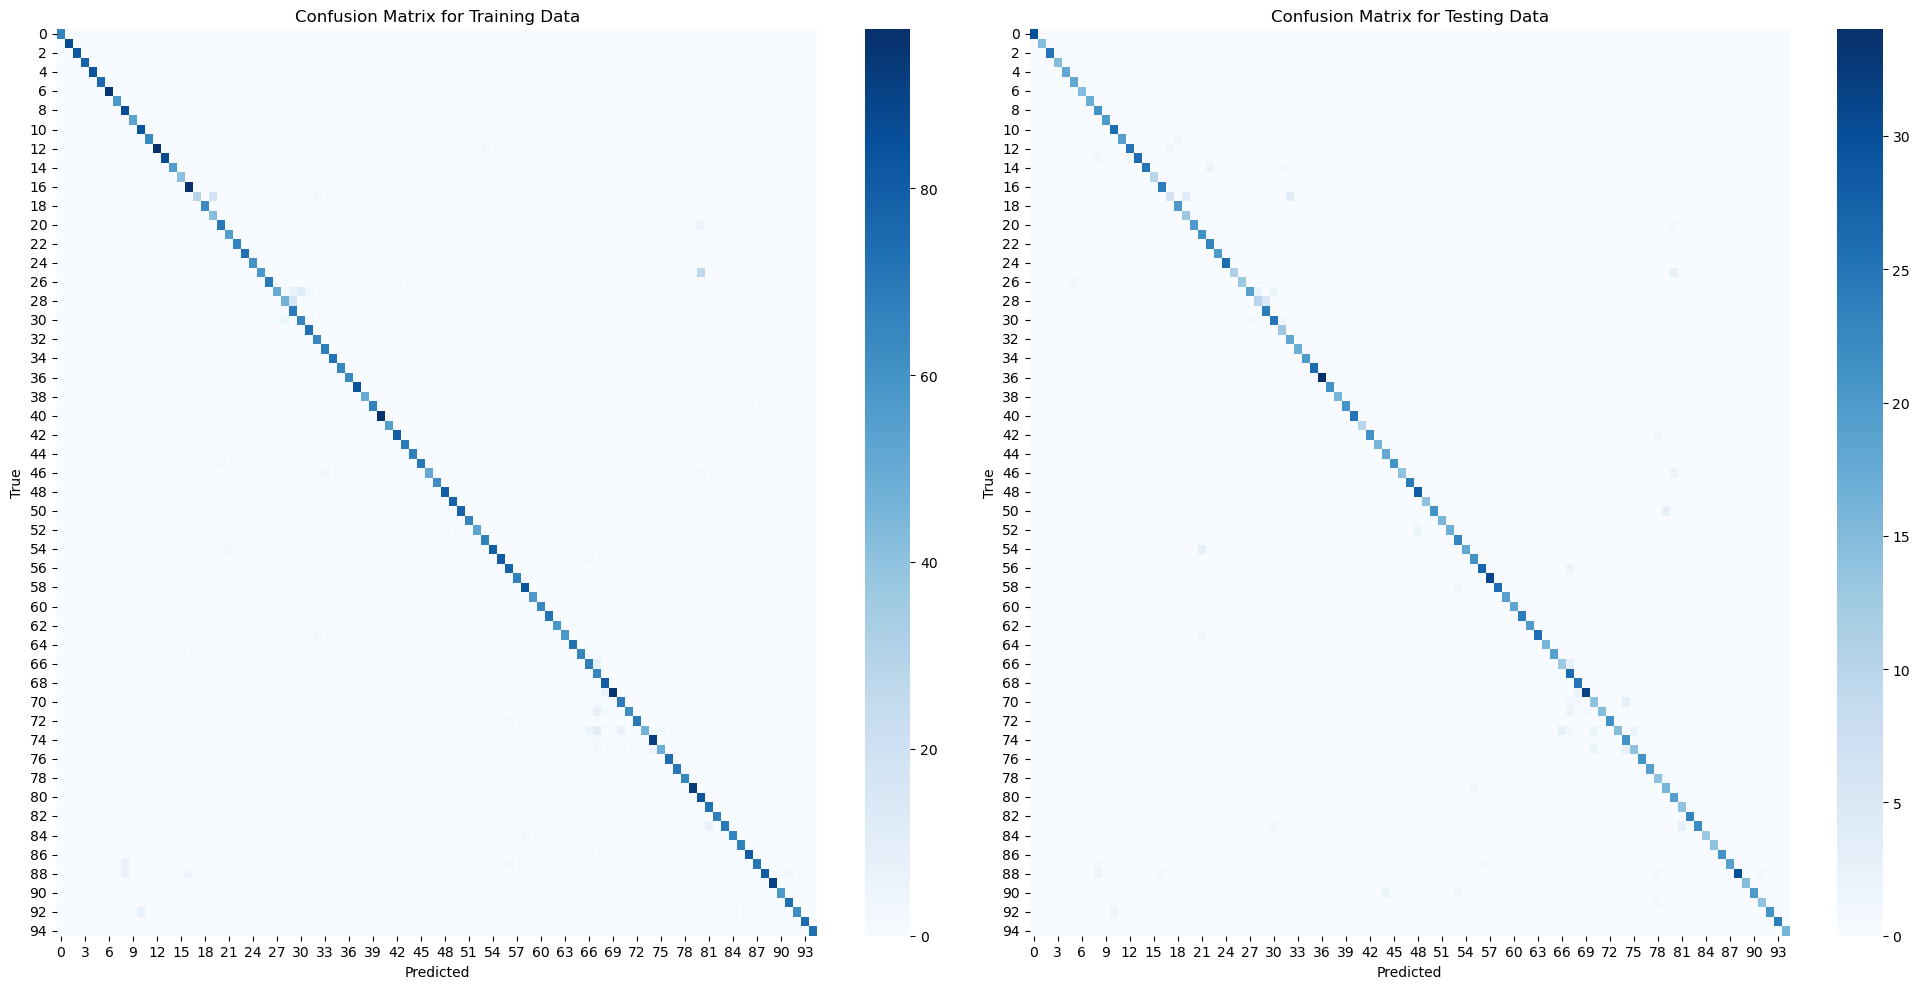

In [17]:
training_predictions, training_targets = accumulate_predictions(classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
#training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
#testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
#print(training_report)
print("Testing Report:")
#print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

In [ ]:
training_predictions, training_targets = accumulate_predictions(improved_classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(improved_classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
#training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
#testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
#print(training_report)
print("Testing Report:")
#print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()